In [ ]:
# --- imports & DB connection (reads creds from .env) ---
import os
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv

load_dotenv()  # expects PG_HOST, PG_PORT, PG_DB, PG_USER, PG_PASSWORD in .env

engine = create_engine(
    f"postgresql+psycopg2://{os.getenv('PG_USER')}:{os.getenv('PG_PASSWORD')}"
    f"@{os.getenv('PG_HOST')}:{os.getenv('PG_PORT')}/{os.getenv('PG_DB')}"
)

print("Connected ✅")

Matplotlib is building the font cache; this may take a moment.


Connected ✅


In [ ]:
# --- sanity checks: counts ---
counts_sql = """
SELECT 'books' AS t, COUNT(*) FROM dwh.books
UNION ALL
SELECT 'fact_rating' AS t, COUNT(*) FROM dwh.fact_rating;
"""
pd.read_sql(counts_sql, engine)

,t,count
0,books,10000
1,fact_rating,979478


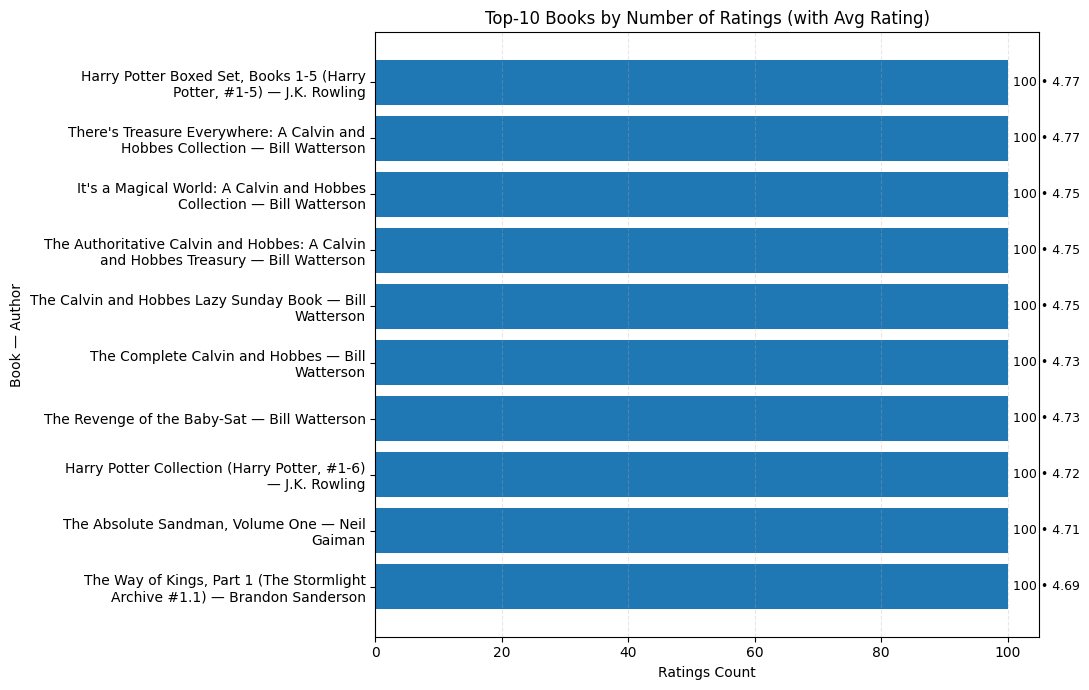

,book_id,source_book_id,title,authors,ratings_count,avg_rating
0,8,3275,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...","J.K. Rowling, Mary GrandPré",100,4.77
1,70489,6361,There's Treasure Everywhere: A Calvin and Hobb...,Bill Watterson,100,4.77
2,24814,4483,It's a Magical World: A Calvin and Hobbes Coll...,Bill Watterson,100,4.75
3,59715,6590,The Authoritative Calvin and Hobbes: A Calvin ...,Bill Watterson,100,4.75
4,24494,5580,The Calvin and Hobbes Lazy Sunday Book,Bill Watterson,100,4.75
5,24812,3628,The Complete Calvin and Hobbes,Bill Watterson,100,4.73
6,121792,8978,The Revenge of the Baby-Sat,Bill Watterson,100,4.73
7,10,3753,"Harry Potter Collection (Harry Potter, #1-6)",J.K. Rowling,100,4.72
8,23753,8109,"The Absolute Sandman, Volume One","Neil Gaiman, Mike Dringenberg, Chris Bachalo, ...",100,4.71
9,9329354,9141,"The Way of Kings, Part 1 (The Stormlight Archi...",Brandon Sanderson,100,4.69


In [9]:
import textwrap
import matplotlib.pyplot as plt
import pandas as pd

sql_top_books = """
SELECT 
  b.book_id,
  b.source_book_id,
  b.title,
  b.authors,
  COUNT(fr.rating)        AS ratings_count,
  ROUND(AVG(fr.rating),2) AS avg_rating
FROM dwh.fact_rating fr
JOIN dwh.books b
  ON b.source_book_id = fr.book_id
GROUP BY b.book_id, b.source_book_id, b.title, b.authors
ORDER BY ratings_count DESC, avg_rating DESC, b.title
LIMIT 10;
"""

df_books = pd.read_sql(sql_top_books, engine)

# Compact, readable labels: "Title — FirstAuthor"
labels = (df_books["title"] + " — " + df_books["authors"].str.split(",").str[0])
# wrap to avoid super long lines
labels_wrapped = [textwrap.fill(s, width=45) for s in labels]

fig, ax = plt.subplots(figsize=(11, 7))
ax.barh(labels_wrapped[::-1], df_books["ratings_count"].iloc[::-1])

# X-axis padding + grid
ax.set_xlim(0, df_books["ratings_count"].max() + 5)
ax.grid(axis="x", linestyle="--", alpha=0.3)

# Add value labels at bar ends: "100 • 4.12"
for y, (n, avg) in enumerate(
    zip(df_books["ratings_count"].iloc[::-1], df_books["avg_rating"].iloc[::-1])
):
    ax.text(n + 0.8, y, f"{int(n)} • {avg:.2f}", va="center", fontsize=9)

ax.set_title("Top-10 Books by Number of Ratings (with Avg Rating)")
ax.set_xlabel("Ratings Count")
ax.set_ylabel("Book — Author")

# more room for long labels on the left
plt.subplots_adjust(left=0.35, right=0.95, top=0.9, bottom=0.08)
plt.tight_layout()
plt.show()

df_books

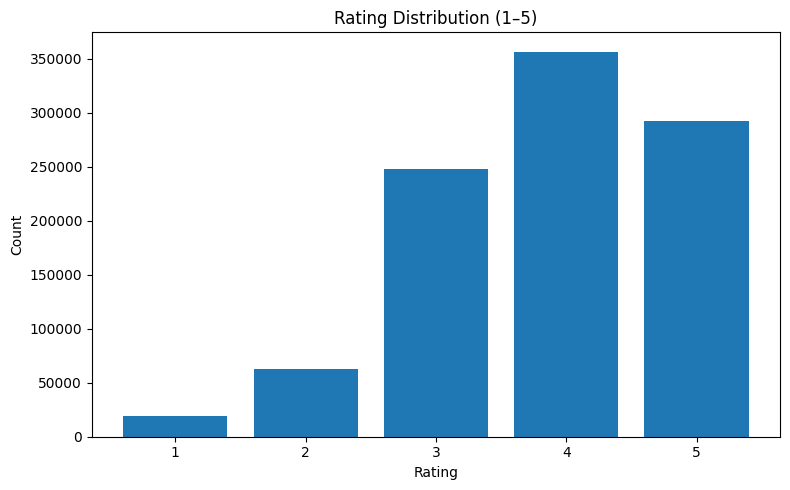

,rating,ratings_count
0,1,19513
1,2,63087
2,3,248076
3,4,356585
4,5,292217


In [ ]:
# --- Rating Distribution 1..5 ---
sql_dist = """
SELECT fr.rating, COUNT(*) AS ratings_count
FROM dwh.fact_rating fr
GROUP BY fr.rating
ORDER BY fr.rating;
"""
df_dist = pd.read_sql(sql_dist, engine)

plt.figure(figsize=(8, 5))
plt.bar(df_dist["rating"].astype(str), df_dist["ratings_count"])
plt.title("Rating Distribution (1–5)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

df_dist

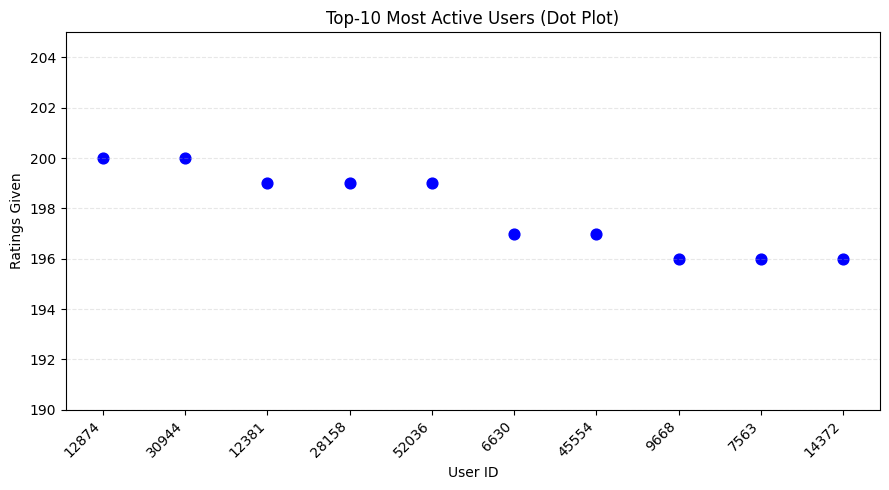

,user_id,ratings_given,avg_rating_given
0,12874,200,3.45
1,30944,200,4.21
2,12381,199,3.43
3,28158,199,3.94
4,52036,199,3.44
5,6630,197,3.57
6,45554,197,4.03
7,9668,196,3.84
8,7563,196,3.50
9,14372,196,3.60


In [4]:
# --- Top-10 Most Active Users (Dot Plot) ---
sql_top_users = """
SELECT
    fr.user_id,
    COUNT(*) AS ratings_given,
    ROUND(AVG(fr.rating), 2) AS avg_rating_given
FROM dwh.fact_rating fr
GROUP BY fr.user_id
ORDER BY ratings_given DESC
LIMIT 10;
"""

df_users = pd.read_sql(sql_top_users, engine)

# Витягуємо дані для візуалізації
xs = df_users["user_id"].astype(str)          # X-axis: user IDs
ys = df_users["ratings_given"]                # Y-axis: number of ratings

plt.figure(figsize=(9, 5))
plt.scatter(xs, ys, s=60, color="blue")       # Dot plot
plt.ylim(190, ys.max() + 5)                   # щоб трохи відсунути від низу
plt.grid(axis='y', linestyle='--', alpha=.3)  # сітка по горизонталі
plt.title("Top-10 Most Active Users (Dot Plot)")
plt.xlabel("User ID")
plt.ylabel("Ratings Given")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

df_users

In [ ]:
# Save last figure (repeat per chart as needed)
out_dir = "notebooks/exports"
os.makedirs(out_dir, exist_ok=True)
plt.gcf().savefig(os.path.join(out_dir, "top10_books.png"), dpi=200)

<Figure size 640x480 with 0 Axes>